In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import os
import matplotlib
from tensorflow import keras
from classes import ModelWrapper, DataLoader, Cluster, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-04-26 08:28:33.730952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Create ensemble
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
names = data_loader.getX17Names(track_type)

#modelAPI1 = ModelWrapper.loadPostprocessed("../models/3D/waveform_spatial_series_compress", "1")
#modelAPI2 = ModelWrapper.loadPostprocessed("../models/3D/small", "2")
#modelAPI3 = ModelWrapper.loadPostprocessed("../models/3D/expand_and_compress_1x1x1", "3")
#modelAPI4 = ModelWrapper.loadPostprocessed("../models/3D/ITERATIVE_4", "4")
#modelAPI5 = ModelWrapper.loadPostprocessed("../models/3D/ITERATIVE_6", "5")


'''rec1 = modelAPI1.evaluateBatch(noisy)
rec2 = modelAPI2.evaluateBatch(noisy)
rec3 = modelAPI3.evaluateBatch(noisy)
rec4 = modelAPI4.evaluateBatch(noisy)

classified1 = modelAPI1.classify(rec1)
classified2 = modelAPI2.classify(rec2)
classified3 = modelAPI3.classify(rec3)
classified4 = modelAPI4.classify(rec4)'''

#modelAPI1 = ModelWrapper(keras.models.load_model("../models/3D/ensemble_lessdeep/model"), "lessdeep")
#modelAPI1 = ModelWrapper(keras.models.load_model("../models/3D/ensemble_deep/model"), "deep")
#modelAPI2 = ModelWrapper(keras.models.load_model("../models/3D/small/model"), "small")
modelAPI1 = ModelWrapper(keras.models.load_model("../models/3D/new_waveform"), "base")
modelAPI2 = ModelWrapper(keras.models.load_model("../models/3D/small/model"), "small")

rec1 = modelAPI1.evaluateBatch(noisy)
rec2 = modelAPI2.evaluateBatch(noisy)

#classified5 = modelAPI5.classify( modelAPI5.evaluateBatch(noisy)

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')
eps = 1e-3

2024-04-26 08:28:36.752972: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


21/21 [==============================] - 4s 192ms/step


In [3]:
#Ensemble rule
#classified = numpy.where(classified1+classified2+classified3+classified4 >= 3, 1, 0)
#classified = numpy.where( (rec1*rec2*rec3) > 0.2, 1, 0 )

#classified = numpy.where( rec1*rec2 > 0.4, 1, 0)

modelAPI = ModelWrapper(keras.models.load_model("../models/ensemble/resulting_ensemble_linear"), "resulting_ensemble")
#combination = modelAPI.model(noisy)

In [4]:
#Save ensemble as one model
'''AE = keras.models.load_model("../models/ensemble/AE")
AE._name = "AE"
waveform = keras.models.load_model("../models/ensemble/waveform")
waveform._name = "waveform"
base = keras.models.load_model("../models/3D/base_with_waveforms/model")
inputs = keras.layers.Input((12,14,208,1))
outputs = AE(inputs)*waveform(inputs)*base(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
keras.models.save_model(model, "../models/ensemble/product")'''

'''M1 = keras.models.load_model("../models/3D/small/model")
M1._name = "M1"
M2 = keras.models.load_model("../models/3D/ensemble_deep/model")
inputs = keras.layers.Input((12,14,208,1))
outputs = M1(inputs)*M2(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
keras.models.save_model(model, "../models/3D/final")'''

'M1 = keras.models.load_model("../models/3D/small/model")\nM1._name = "M1"\nM2 = keras.models.load_model("../models/3D/ensemble_deep/model")\ninputs = keras.layers.Input((12,14,208,1))\noutputs = M1(inputs)*M2(inputs)\nmodel = keras.Model(inputs=inputs, outputs=outputs)\nkeras.models.save_model(model, "../models/3D/final")'

In [5]:
#print(numpy.nonzero(numpy.where(combination[0]>0.3,combination[0],0)))
'''certainty = lambda x:	numpy.abs(x-0.5)
combination = (certainty(rec1)*rec1 + certainty(rec2)*rec2 + certainty(rec3)*rec3) / (certainty(rec1)+certainty(rec2)+certainty(rec3))
classified = numpy.where( combination > 0.3, 1, 0)'''
combination = rec1*rec2
#combination = modelAPI.evaluateBatch(noisy)
classified = numpy.where( combination > 0.001, 1, 0)

In [6]:
#Get good cluster numbers
good_c = 0
all_c = 0
good_e = 0

print("NN:")

for i in range(classified.shape[0]):
	increase = False
	for cluster in Cluster.clusterise(classified[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	
		#if cluster.getPassedTestsNum() >= 3:
			good_c += 1
			increase = True
		all_c += 1
	good_e += increase
print("all clusters:", all_c) 
print("good clusters:", good_c)
print("relative precision:", good_c / all_c)
print("good events:", good_e)
print("--------------------")

print("non-NN:")

good_c = 0
all_c = 0
good_e = 0

for i in range(clean.shape[0]):
	increase = False
	for cluster in Cluster.clusterise(clean[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	
		#if cluster.getPassedTestsNum() >= 3:
			good_c += 1
			increase = True
		all_c += 1
	good_e += increase
print("all clusters:", all_c) 
print("good clusters:", good_c)
print("relative precision:", good_c / all_c)
print("good events:", good_e)

NN:


/home/gajdoma6/UTEF/track_denoiser/notebooks/../classes.py:237: RuntimeWarning: invalid value encountered in double_scalars
  self.energy_density = self.energy / self.effective_length


all clusters: 854
good clusters: 257
relative precision: 0.3009367681498829
good events: 219
--------------------
non-NN:
all clusters: 815
good clusters: 288
relative precision: 0.35337423312883437
good events: 234


In [7]:
#Fragmentation analysis
NN_all = 0
NN_good = []
nonNN_all = 0
nonNN_good = []
NN_fragmentation_number = 0
nonNN_fragmentation_number = 0

for i in range(classified.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)
	
	NN_fragmentation_number += len(clusters_NN) - len(clusters_NN_defrag)
	nonNN_fragmentation_number += len(clusters_nonNN) - len(clusters_nonNN_defrag)

	for cluster in clusters_nonNN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	nonNN_good.append(i)
		nonNN_all += 1

	for cluster in clusters_NN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	NN_good.append(i)
		NN_all += 1

print("# nonNN clusters after defragmentation:", nonNN_all)
print("# nonNN good clusters after defragmentation:", len(nonNN_good))
print("# NN clusters after defragmentation:", NN_all)
print("# NN good clusters after defragmentation:", len(NN_good))
print("")
print("nonNN relative precision:", len(nonNN_good) / nonNN_all)
print("NN relative precision:", len(NN_good) / NN_all)
print("")
print("nonNN fragmentation number:", nonNN_fragmentation_number)
print("NN fragmentation number:", NN_fragmentation_number)

# nonNN clusters after defragmentation: 618
# nonNN good clusters after defragmentation: 285
# NN clusters after defragmentation: 850
# NN good clusters after defragmentation: 256

nonNN relative precision: 0.46116504854368934
NN relative precision: 0.30117647058823527

nonNN fragmentation number: 197
NN fragmentation number: 4


In [8]:
#Numbers for set plot - clusters
counter = 0
for event in noisy:
	counter += len(Cluster.clusterise((event)))
print("All clusters:", counter)

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		}
	}

lone = {
	"NN":	{
		"all": 0,
		"good": 0
	},
	"nonNN":	{
		"all": 0,
		"good": 0
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	table["NN"]["fragmented"]["all"] += len(clusters_NN)
	table["NN"]["defragmented"]["all"] += len(clusters_NN_defrag)
	table["nonNN"]["fragmented"]["all"] += len(clusters_nonNN)
	table["nonNN"]["defragmented"]["all"] += len(clusters_nonNN_defrag)

	for cluster in clusters_NN:	table["NN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN:	table["nonNN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_NN_defrag:	table["NN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN_defrag:	table["nonNN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []

	nonNN_subset_of_NN, NN_subset_of_nonNN = Cluster.crossconnectClusters(clusters_nonNN, clusters_NN)
	nonNN_are_disconnected = [True]*len(clusters_nonNN)
	NN_are_disconnected = [True]*len(clusters_NN)
	for j in range( len(nonNN_subset_of_NN) ):
		if nonNN_subset_of_NN[j] != None:
			NN_are_disconnected[ nonNN_subset_of_NN[j] ] = False
			nonNN_are_disconnected[j] = False
	for j in range( len(NN_subset_of_nonNN) ):
		if NN_subset_of_nonNN[j] != None:
			nonNN_are_disconnected[ NN_subset_of_nonNN[j] ] = False
			NN_are_disconnected[j] = False
	
	for j in range( len(nonNN_are_disconnected) ):
		if nonNN_are_disconnected[j]:
			lone["nonNN"]["all"] += 1
			if evaluate(clusters_nonNN[j], noisy_with_E[i]):	lone["nonNN"]["good"] += 1
	for j in range( len(NN_are_disconnected) ):
		if NN_are_disconnected[j]:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1

	'''for j in range( len(NN_subset_of_nonNN) ):	
		if NN_subset_of_nonNN[j] == None:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1'''

print("BEFORE DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["fragmented"]["all"])
print("All NN:", table["NN"]["fragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["fragmented"]["good"]))
print("Good NN:", len(table["NN"]["fragmented"]["good"]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["defragmented"]["all"])
print("All NN:", table["NN"]["defragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["defragmented"]["good"]))
print("Good NN:", len(table["NN"]["defragmented"]["good"]))

print("--------------------------------")

print("Lone nonNN:", lone["nonNN"]["all"])
print("Lone NN:", lone["NN"]["all"])
print("Lone good nonNN:", lone["nonNN"]["good"])
print("Lone good NN:", lone["NN"]["good"])

All clusters: 5926
BEFORE DEFRAGMENTATION:
All nonNN: 815
All NN: 854
Good nonNN: 288
Good NN: 257
--------------------------------
AFTER DEFRAGMENTATION:
All nonNN: 618
All NN: 850
Good nonNN: 285
Good NN: 256
--------------------------------
Lone nonNN: 186
Lone NN: 418
Lone good nonNN: 17
Lone good NN: 16


In [9]:
#Numbers for set plot - events
counter = 0

print("All:", noisy.shape[0])

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	truth_good_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN]
	truth_good_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN]
	truth_good_defrag_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN_defrag]
	truth_good_defrag_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN_defrag]

	table["NN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_NN) else []
	table["NN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_NN) != 0 and all(truth_good_NN) else []
	table["NN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_NN) else []
	table["NN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_NN) != 0 and all(truth_good_defrag_NN) else []
	table["nonNN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_nonNN) else []
	table["nonNN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_nonNN) != 0 and all(truth_good_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_nonNN) != 0 and all(truth_good_defrag_nonNN) else []


print("BEFORE DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["fragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["fragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["fragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["fragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["fragmented"]["good"]["any"] if i not in table["NN"]["fragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["fragmented"]["good"]["any"] if i not in table["nonNN"]["fragmented"]["good"]["any"]]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["defragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["defragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["defragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["defragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["defragmented"]["good"]["any"] if i not in table["NN"]["defragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["defragmented"]["good"]["any"] if i not in table["nonNN"]["defragmented"]["good"]["any"]]))

All: 641
BEFORE DEFRAGMENTATION:
At least one good nonNN: 234
All good nonNN: 71
At least one good NN: 219
All good NN: 85
At least one good nonNN no good NN: 41
At least one good NN no good nonNN: 26
--------------------------------
AFTER DEFRAGMENTATION:
At least one good nonNN: 248
All good nonNN: 115
At least one good NN: 219
All good NN: 85
At least one good nonNN no good NN: 43
At least one good NN no good nonNN: 14


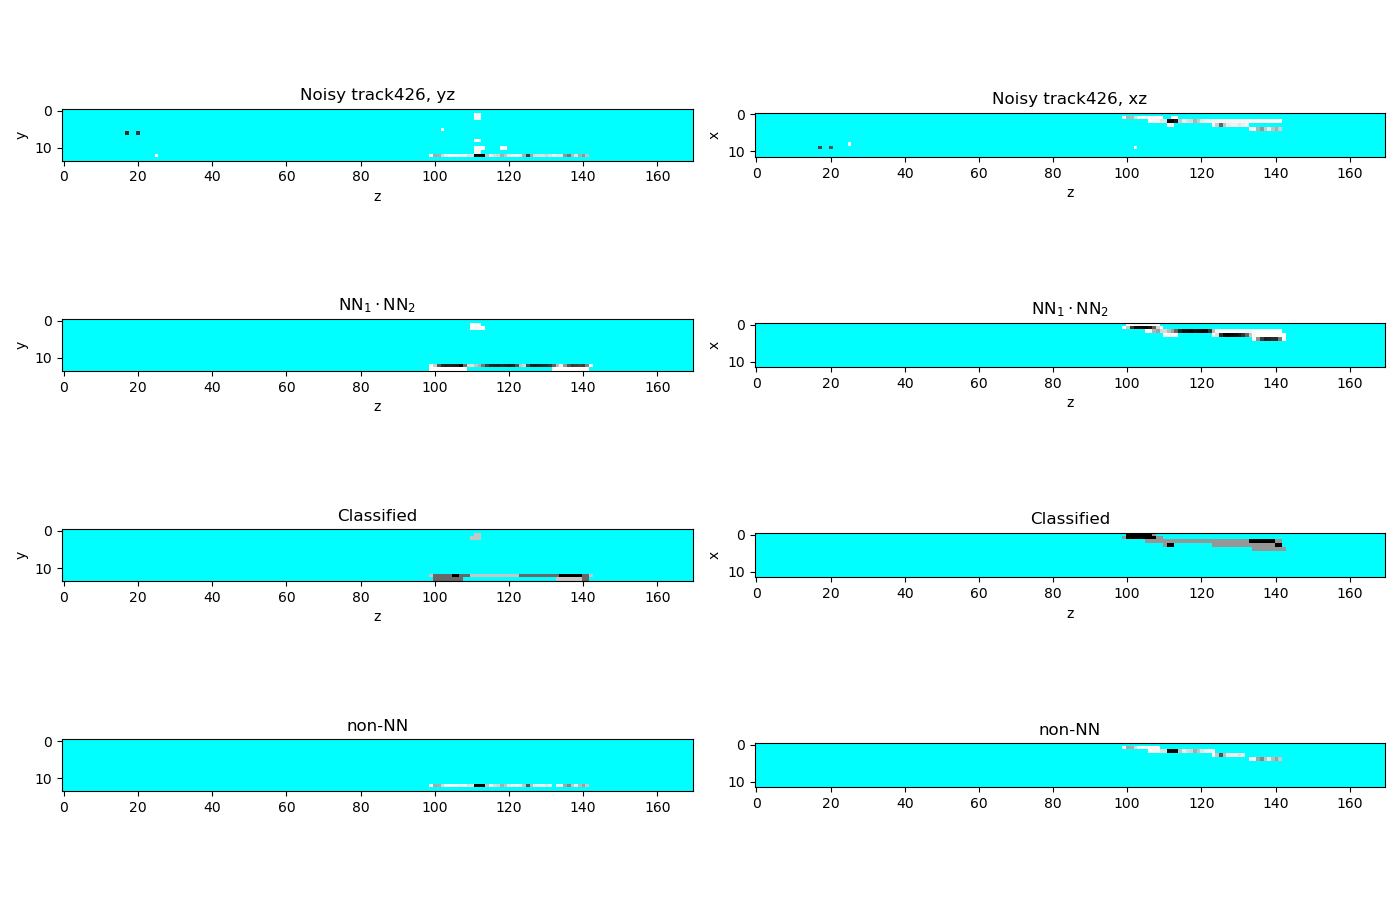

L = 108 L_ef = 63 , N_coef = 8.277777777777779 , E/L =  211.12698412698413 , tests: {'length': True, 'zone': True, 'neighbours': False, 'energy_density': True}
L = 5 L_ef = 4 , N_coef = 4.2 , E/L =  56.25 , tests: {'length': False, 'zone': True, 'neighbours': True, 'energy_density': False}


In [10]:
#Show reconstruction
#index = numpy.random.randint(noisy.shape[0])
index = numpy.random.default_rng().choice([i for i in table["nonNN"]["defragmented"]["good"]["any"] if i not in table["NN"]["defragmented"]["good"]["any"]])
#axis = 1

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(4,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))
	#ax[0,1].imshow(numpy.sum(rec1[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec1[index])])/2)
	#ax[0,1].set_title("lessdeep")
	#ax[1,1].imshow(numpy.sum(rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec2[index])])/2)
	#ax[1,1].set_title("Hybrid")
	ax[1,axis].imshow(numpy.sum(rec1[index]*rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec1[index]*rec2[index])])/2)
	ax[1,axis].set_title(r"$\text{NN}_1 \cdot \text{NN}_2$")
	#ax[4].imshow(numpy.sum(rec2[index]*rec1[index]*numpy.where(noisy[index]>0,1,0), 0), cmap, vmin=numpy.min([eps, numpy.max(rec2[index]*rec1[index]*noisy[index])])/2)
	#ax[4].set_title("AE*Waveform*noisy")
	#ax[1,0].imshow(numpy.sum(combination[index], 0)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(combination[index])])/2)
	#ax[1,0].set_title("Ensemble")
	ax[3,axis].imshow(numpy.sum(clean[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(clean[index])])/2)
	ax[3,axis].set_title("non-NN")
	ax[2,axis].imshow(numpy.sum(classified[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(classified[index])])/2)
	ax[2,axis].set_title("Classified")
	for i in range(3):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")
fig.set_size_inches(14, 9)
fig.tight_layout()
matplotlib.pyplot.show()

for cluster in Cluster.clusterise(classified[index]):
	cluster.setEnergy(noisy_with_E[index])
	cluster.runTests()
	print("L =", cluster.length, "L_ef =", cluster.effective_length, ", N_coef =", cluster.neighbour_coef, ", E/L = ", cluster.energy_density, ", tests:", cluster.tests)

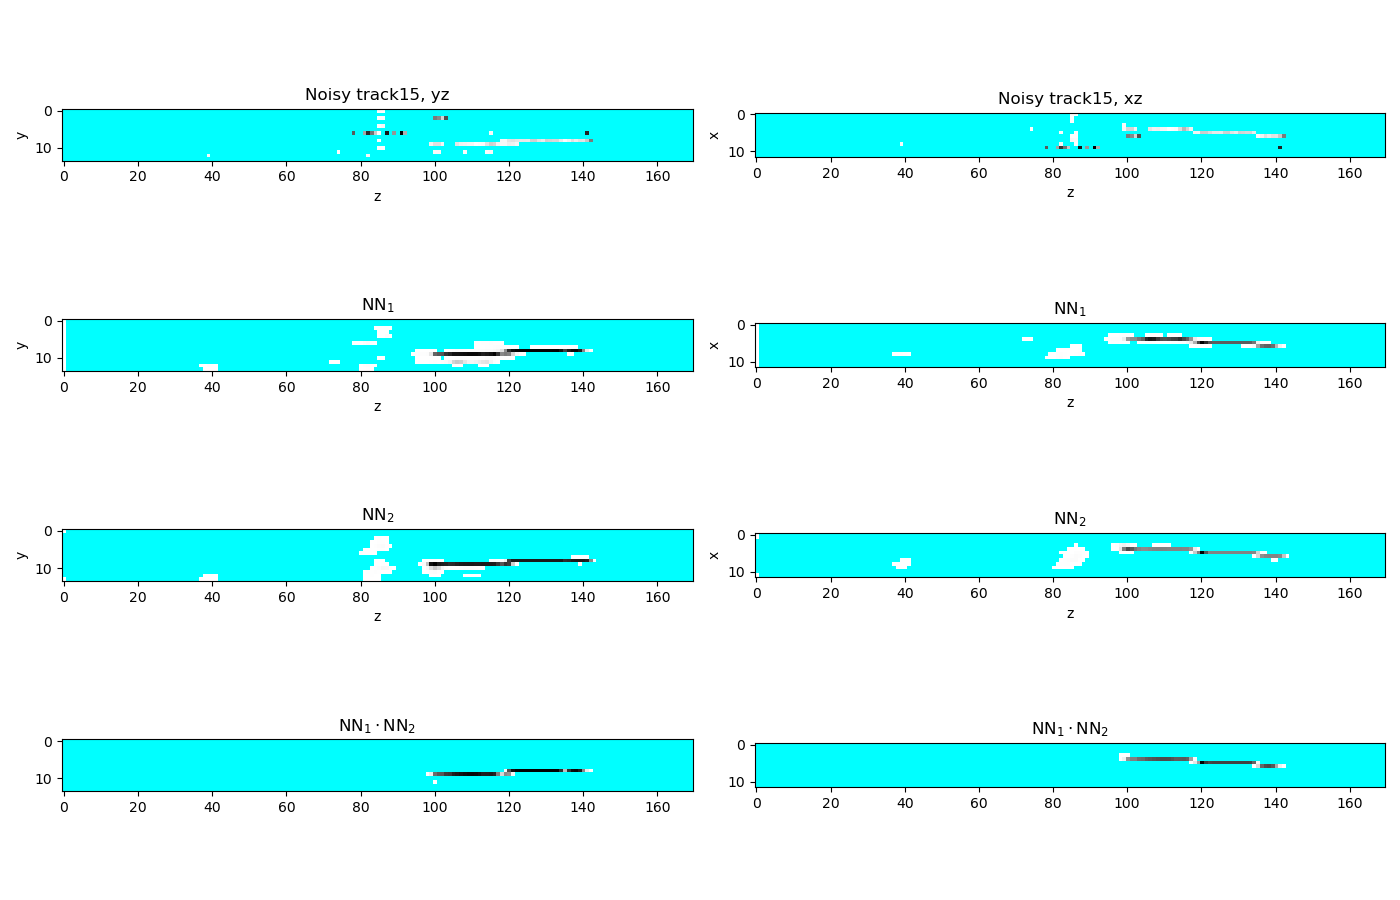

No such comm: 71db79641cb64ed18134b5c8c5e11b9e
No such comm: 71db79641cb64ed18134b5c8c5e11b9e


In [11]:
#Show models and product
index = numpy.random.randint(noisy.shape[0])
#axis = 1

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(4,2)
for axis in [0,1]:
	ax[0,axis].imshow(numpy.sum(noisy[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(noisy[index])])/2)
	ax[0,axis].set_title("Noisy " + names[index] + (", yz" if axis == 0 else ", xz"))
	#ax[0,1].imshow(numpy.sum(rec1[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec1[index])])/2)
	#ax[0,1].set_title("lessdeep")
	#ax[1,1].imshow(numpy.sum(rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec2[index])])/2)
	#ax[1,1].set_title("Hybrid")
	ax[3,axis].imshow(numpy.sum(rec1[index]*rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec1[index]*rec2[index])])/2)
	ax[3,axis].set_title(r"$\text{NN}_1 \cdot \text{NN}_2$")
	#ax[4].imshow(numpy.sum(rec2[index]*rec1[index]*numpy.where(noisy[index]>0,1,0), 0), cmap, vmin=numpy.min([eps, numpy.max(rec2[index]*rec1[index]*noisy[index])])/2)
	#ax[4].set_title("AE*Waveform*noisy")
	#ax[1,0].imshow(numpy.sum(combination[index], 0)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(combination[index])])/2)
	#ax[1,0].set_title("Ensemble")
	ax[1,axis].imshow(numpy.sum(rec1[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec1[index])])/2)
	ax[1,axis].set_title(r"$\text{NN}_1$")
	ax[2,axis].imshow(numpy.sum(rec2[index], axis)[:,0:170], cmap, vmin=numpy.min([eps, numpy.max(rec2[index])])/2)
	ax[2,axis].set_title(r"$\text{NN}_2$")
	for i in range(3):
		ax[i,axis].set_xlabel("z")
		ax[i,axis].set_ylabel("y" if axis == 0 else "x")
fig.set_size_inches(14, 9)
fig.tight_layout()
matplotlib.pyplot.show()